## Stable Diffusion Hacking 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# from diffusers import StableDiffusion3Pipeline
from diffusers import StableDiffusionPipeline
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.utils.torch_utils import randn_tensor

In [2]:
# model_id = "stabilityai/stable-diffusion-2"
model_id = "stabilityai/stable-diffusion-2-1"

# Use the Euler scheduler here instead
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") #Woah so different!
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler") 
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler") 
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
# StableDiffusionPipeline.from_pretrained?

In [12]:
# prompt = "a photo of an astronaut riding a horse on mars"
prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
# prompt="A picture of a mad face with a mouth"
# prompt="The image depicts a humorous and surreal scene on a highway. An elderlywoman is riding a classic bicycle, speeding down the road at an astonishing pace. Her expression is one of determination, mixed with a hint of joy, while her scarf flutters wildly in the wind, emphasizing her incredible speed. Next to her, a sleek, modern sports car is visibly being overtaken. The driver, wide-eyed and astonished, glances at the speeding grandmother in disbelief. The highway scenery is blurred with motion streaks and light trails, enhancing the sense of extreme velocity. Dust and wind effects swirl around the bicycle wheels, creating an impression of a high-speed race. The sky above is bright blue with a few clouds, and modern road signs add to the dynamic urban setting.extrem funny"
# prompt="black and white photography, fashion editorial, a silhouette of woman with abstract hair in black and white, art concept, highres, realistic photo, professional photography, cinematic angle, dynamic light back shining,"
# prompt="fashion editorial, highly detailed photo, fashion photography, old paper close-up black haired girl with closed eyes in depression and anxiety, portrait, beauty, minimalist, decorative full flowing intricate fine detail, highres, realistic photo, professional photography, cinematic angle, dynamic light back shining,"
# generator = torch.Generator(device="cuda").manual_seed(8)
generator = torch.Generator(device="cuda").manual_seed(13)
image = pipe(prompt, guidance_scale=1.0, generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

NEED TO CHECK IF 1 or 0 mean "no guidance" !! Ok yeah 1 is no guidance. cool. 

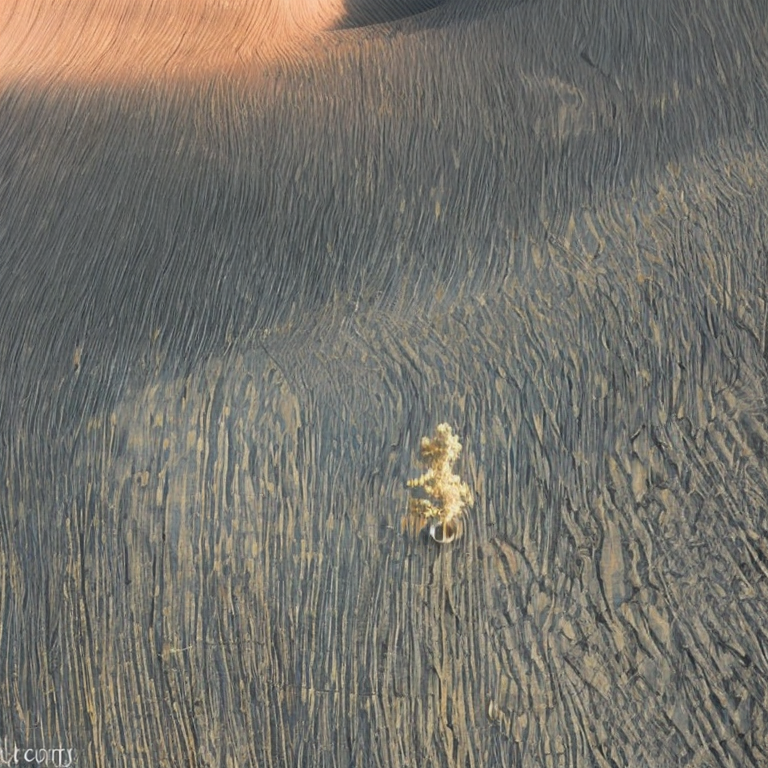

In [13]:
image

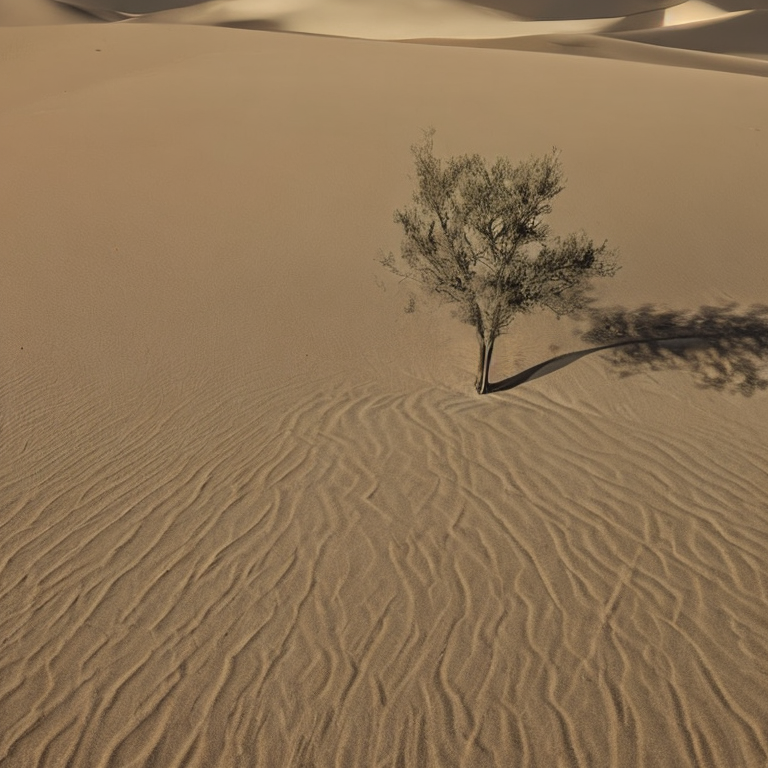

In [70]:
image

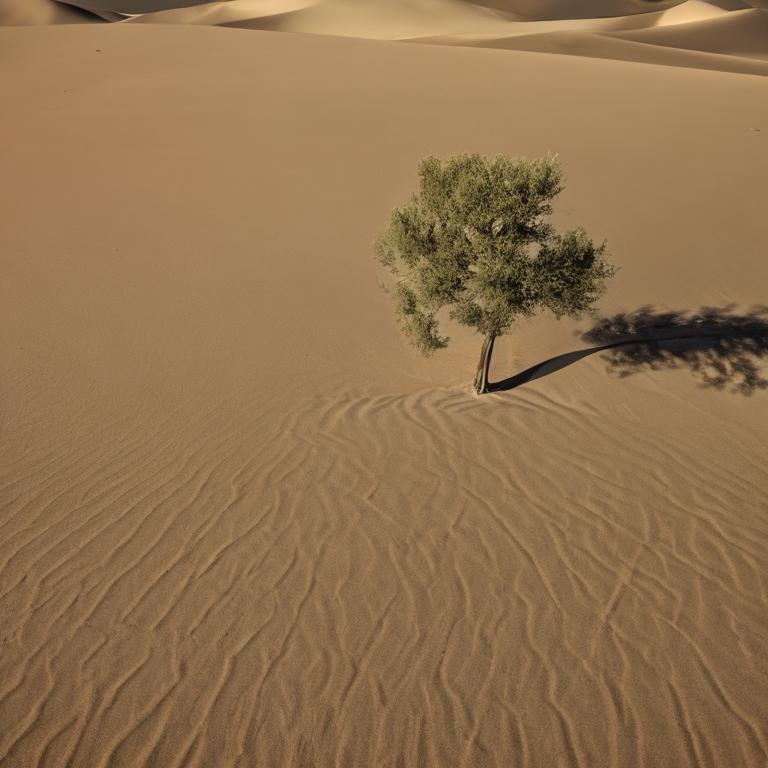

In [67]:
image

In [6]:
# pipe.scheduler.compatibles

In [34]:
pipe?

Signature:     
pipe(
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    timesteps: List[int] = None,
    sigmas: List[float] = None,
    guidance_scale: float = 7.5,
    negative_prompt: Union[str, List[str], NoneType] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None,
    latents: Optional[torch.Tensor] = None,
    prompt_embeds: Optional[torch.Tensor] = None,
    negative_prompt_embeds: Optional[torch.Tensor] = None,
    ip_adapter_image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor], NoneType] = None,
    ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
    output_type: Optional[str] = 'pil',
    return_dict: bool = True,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    guidance_res

- Ok, let me see if I can take apart this `EulerDiscreteScheduler`
- Hmm actually I think i should take apart pipe first

In [7]:
# pipe.scheduler

In [8]:
prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
height = None
width = None
num_inference_steps = 50
timesteps =  None
sigmas = None
guidance_scale = 1.0
negative_prompt = None
num_images_per_prompt= 1
eta = 0.0
generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds = None
ip_adapter_image =None
ip_adapter_image_embeds= None
output_type= "pil"
return_dict = True
cross_attention_kwargs = None
guidance_rescale = 0.0
clip_skip = None
callback_on_step_end = None
callback_on_step_end_tensor_inputs = ["latents"]

In [9]:
#Actually let's try fixing the seed. 
generator = torch.Generator(device="cuda").manual_seed(8)

In [10]:
if not height or not width:
    height = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[0]
    )
    width = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[1]
    )
    height, width = height * pipe.vae_scale_factor, width * pipe.vae_scale_factor

In [11]:
pipe._guidance_scale = guidance_scale
pipe._guidance_rescale = guidance_rescale
pipe._clip_skip = clip_skip
pipe._cross_attention_kwargs = cross_attention_kwargs
pipe._interrupt = False

In [12]:
# 2. Define call parameters
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
elif prompt is not None and isinstance(prompt, list):
    batch_size = len(prompt)
else:
    batch_size = prompt_embeds.shape[0]

device = pipe._execution_device

In [13]:
batch_size

1

In [14]:
# 3. Encode input prompt
lora_scale = (
    pipe.cross_attention_kwargs.get("scale", None) if pipe.cross_attention_kwargs is not None else None
)

prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    pipe.do_classifier_free_guidance,
    negative_prompt,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    lora_scale=lora_scale,
    clip_skip=pipe.clip_skip,
)

In [15]:
# For classifier free guidance, we need to do two forward passes.
# Here we concatenate the unconditional and text embeddings into a single batch
# to avoid doing two forward passes
if pipe.do_classifier_free_guidance:
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
    image_embeds = self.prepare_ip_adapter_image_embeds(
        ip_adapter_image,
        ip_adapter_image_embeds,
        device,
        batch_size * num_images_per_prompt,
        pipe.do_classifier_free_guidance,
    )

In [16]:
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps

In [17]:
# 4. Prepare timesteps
timesteps, num_inference_steps = retrieve_timesteps(
    pipe.scheduler, num_inference_steps, device, timesteps, sigmas
)


In [18]:
timesteps

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')

In [19]:
# num_inference_steps

In [20]:
# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [21]:
latents.shape

torch.Size([1, 4, 96, 96])

In [22]:
# 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

# 6.1 Add image embeds for IP-Adapter
added_cond_kwargs = (
    {"image_embeds": image_embeds}
    if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
    else None
)

# 6.2 Optionally get Guidance Scale Embedding
timestep_cond = None
if pipe.unet.config.time_cond_proj_dim is not None:
    guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
    timestep_cond = self.get_guidance_scale_embedding(
        guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
    ).to(device=device, dtype=latents.dtype)

- Ok, now can i creak into `pipe.scheduler.step`?

In [23]:
# pipe.scheduler.config.prediction_type = "v_prediction" #Try simpler prediction type, v_prediction is the only one giving good results right now. 

In [24]:
res={'latent_model_input':[], 'noise_pred_uncond':[], 'noise_pred_text':[], 'noise_pred':[], 'latents':[]}

# 7. Denoising loop
with torch.no_grad():
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    pipe._num_timesteps = len(timesteps)
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # if pipe.interrupt:
            #     continue

            res['latent_model_input'].append(latents.detach().cpu().numpy())
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if pipe.do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=pipe.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]
    
            # perform guidance
            if pipe.do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)

            res['noise_pred_uncond'].append(noise_pred_uncond.detach().cpu().numpy())
            res['noise_pred_text'].append(noise_pred_text.detach().cpu().numpy())
            res['noise_pred'].append(noise_pred.detach().cpu().numpy())

            if pipe.do_classifier_free_guidance and pipe.guidance_rescale > 0.0: #pipe.guidance_rescale=0.0
                # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=pipe.guidance_rescale)
    
            # compute the previous noisy sample x_t -> x_t-1
            # latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

            ## --- Scheduler override --- ##
            ## DDIM Scheduler
            # self,
            model_output = noise_pred
            timestep = t
            sample = latents
            eta = 0.0
            use_clipped_model_output = False
            generator=generator
            variance_noise =  None
            return_dict = False
            
            # 1. get previous step value (=t-1)
            prev_timestep = timestep - pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
            
            
            # 2. compute alphas, betas
            alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pipe.scheduler.final_alpha_cumprod
            
            beta_prod_t = 1 - alpha_prod_t
            
            # 3. compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            if  pipe.scheduler.config.prediction_type == "epsilon":
                pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
                pred_epsilon = model_output
            elif  pipe.scheduler.config.prediction_type == "sample":
                pred_original_sample = model_output
                pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)
            elif  pipe.scheduler.config.prediction_type == "v_prediction":
                pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
                pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
            else:
                raise ValueError(
                    f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                    " `v_prediction`")
            
            # 4. Clip or threshold "predicted x_0"
            if pipe.scheduler.config.thresholding: #False
                pred_original_sample = self._threshold_sample(pred_original_sample)
            elif pipe.scheduler.config.clip_sample: #False
                pred_original_sample = pred_original_sample.clamp(
                    -self.config.clip_sample_range, self.config.clip_sample_range
                )
            
            # 5. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            variance = pipe.scheduler._get_variance(timestep, prev_timestep)
            std_dev_t = eta * variance ** (0.5)
            
            if use_clipped_model_output: #False
                # the pred_epsilon is always re-derived from the clipped x_0 in Glide
                pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

            #SW - this might be a cleaner way to perturb things
            # alpha_prod_t_prev=1.01*alpha_prod_t_prev
            
            # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * pred_epsilon

            
            # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

            ## 7 variant - SW Pertebation
            # prev_sample = 1.01*alpha_prod_t_prev ** (0.5) * pred_original_sample + 0.99*pred_sample_direction
            
            
            if eta > 0:
                if variance_noise is not None and generator is not None:
                    raise ValueError(
                        "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
                        " `variance_noise` stays `None`."
                    )
            
                if variance_noise is None:
                    variance_noise = randn_tensor(
                        model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype
                    )
                variance = std_dev_t * variance_noise
            
                prev_sample = prev_sample + variance
    
            latents = prev_sample
            ### --- end scheduler hacking ---- ###
            
            res['latents'].append(latents.detach().cpu().numpy())

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()

            # if i == 35: break #Stop early to dig into scheduler

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'noise_pred_uncond' is not defined

In [ ]:
if not output_type == "latent":
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[
        0
    ]
    image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)
else:
    image = latents
    has_nsfw_concept = None

if has_nsfw_concept is None:
    do_denormalize = [True] * image.shape[0]
else:
    do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
image = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=do_denormalize)


In [ ]:
image[0]

- Woah holy shit for DDPM sampling, adding the noise matter a lot!
- That sampling method seems to matter a lot too - woah
- Ok I think i want to try one more little thing here - just like my own naive approach. 

In [ ]:
assert False